In [1]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import pathlib
root_path = r"C:\Users\jdeblander\LiveProjects\Image classification\Data"

train_data_dir = f"{root_path}/train/"
train_data_dir = pathlib.Path(train_data_dir)

val_data_dir = f"{root_path}/validation/"
val_data_dir = pathlib.Path(val_data_dir)

test_data_dir = f"{root_path}/test/"
test_data_dir = pathlib.Path(test_data_dir)

print(f"Training data from path: {train_data_dir},\nValidation data from path: {val_data_dir},\nTest data from path: {test_data_dir}")

Training data from path: C:\Users\jdeblander\LiveProjects\Image classification\Data\train,
Validation data from path: C:\Users\jdeblander\LiveProjects\Image classification\Data\validation,
Test data from path: C:\Users\jdeblander\LiveProjects\Image classification\Data\test


In [6]:
train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
val_image_count = len(list(val_data_dir.glob('*/*.jpg')))

print(f"Number of train images: {train_image_count},\nNumber of val images: {val_image_count},\nNumber of test images: {test_image_count}")

Number of train images: 2400,
Number of val images: 800,
Number of test images: 800


In [7]:
import numpy as np
class_names = np.array([item.name for item in train_data_dir.glob('*')])
print(f"Class names: {class_names}")

Class names: ['swift' 'wagonr']


In [8]:
batch_size = 32
img_height = 100
img_width = 100
steps_per_epoch = np.ceil(train_image_count/batch_size)

In [9]:
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

In [10]:
def get_label(file_path):
      # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == class_names[0]

In [15]:
def decode_img(img):
      # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
     # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [img_width, img_height])

In [16]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [17]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_list_ds.map(process_path, 
                                     num_parallel_calls=AUTOTUNE)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
val_labeled_ds = val_list_ds.map(process_path, 
                                 num_parallel_calls=AUTOTUNE)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_labeled_ds = test_list_ds.map(process_path, 
                                   num_parallel_calls=AUTOTUNE)

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
      # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [19]:
def prepare_for_testing(ds, cache=True):
      # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [24]:
import matplotlib.pyplot as plt
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[0] if label_batch[n]==True else class_names[1])
    #   plt.title(class_names[label_batch[n]==class_names[0]][0].title())
        plt.axis('off')

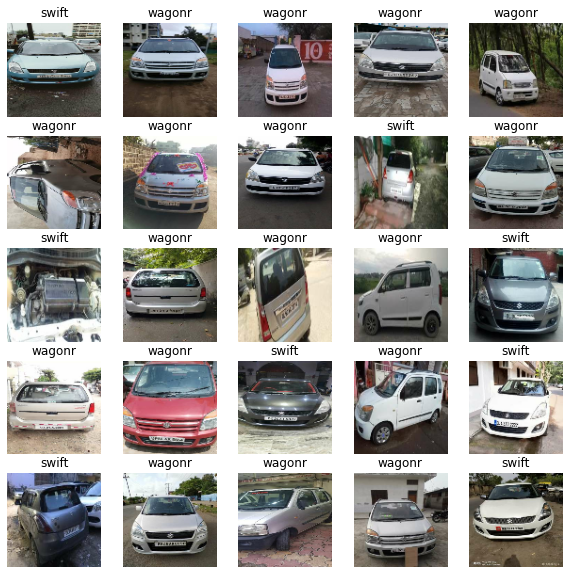

In [25]:
train_ds = prepare_for_training(train_labeled_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

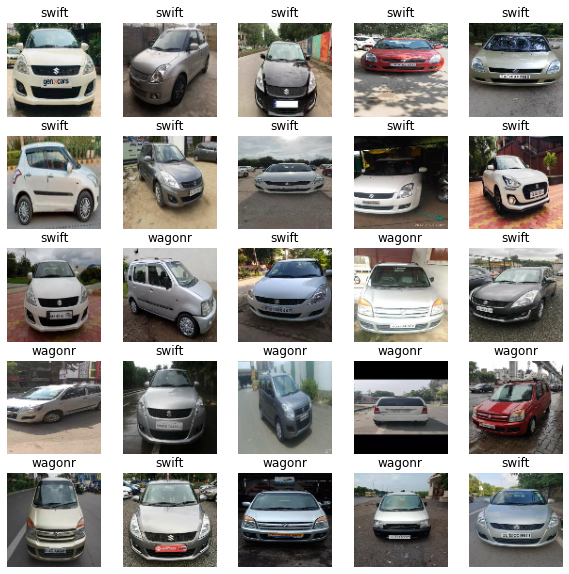

In [26]:
val_ds = prepare_for_testing(val_labeled_ds)

image_batch, label_batch = next(iter(val_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

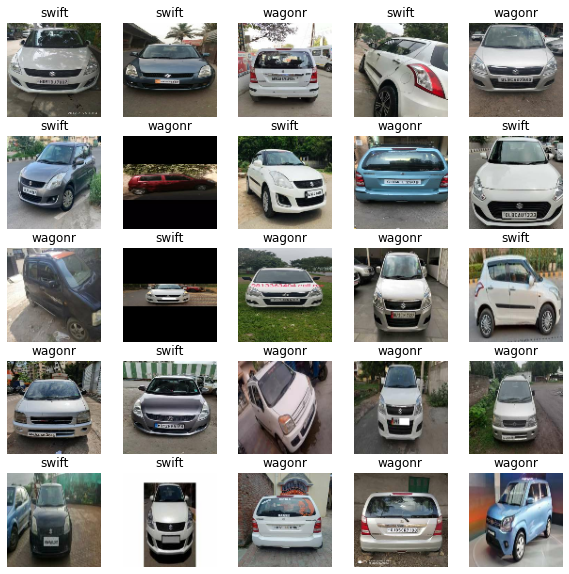

In [27]:
test_ds = prepare_for_testing(test_labeled_ds)

image_batch, label_batch = next(iter(test_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
input_shape = (100, 100, 3)
num_outputs = 1
num_epochs = 10

In [30]:
from  tensorflow import keras
def get_model(input_shape, num_neurons, num_outputs):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(num_neurons, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(num_outputs, activation='softmax')
    ])
    
    return model

In [31]:
num_neurons = 64
three_layer_64 = get_model(input_shape, num_neurons, num_outputs)
three_layer_64.compile(optimizer='adam',
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy'])

logdir = f"logs/scalars/three_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = three_layer_64.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = three_layer_64.evaluate(val_ds, verbose=2)
test_loss, test_acc = three_layer_64.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10


C:\Users\jdeblander\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


75/75 [==============================] - 9s 67ms/step - loss: 1.0264 - accuracy: 0.5000 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 2s 23ms/step - loss: 0.7521 - accuracy: 0.5000 - val_loss: 0.6640 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 2s 23ms/step - loss: 0.6523 - accuracy: 0.5000 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 2s 21ms/step - loss: 0.7392 - accuracy: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 20ms/step - loss: 0.6424 - accuracy: 0.5000 - val_loss: 0.7354 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 2s 30ms/step - loss: 0.6275 - accuracy: 0.5000 - val_loss: 0.6655 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 2s 33ms/step - loss: 0.6100 - accuracy: 0.5000 - val_loss: 0.7037 - val_accuracy: 0.5000
Epoch 8/10
75/75 [======

In [32]:
num_neurons = 128
three_layer_128 = get_model(input_shape, num_neurons, num_outputs)
three_layer_128.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = f"logs/scalars/three_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = three_layer_128.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = three_layer_128.evaluate(val_ds, verbose=2)
test_loss, test_acc = three_layer_128.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10
75/75 [==============================] - 4s 39ms/step - loss: 0.9678 - accuracy: 0.5000 - val_loss: 0.8279 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 3s 36ms/step - loss: 0.7241 - accuracy: 0.5000 - val_loss: 0.6584 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 2s 32ms/step - loss: 0.6827 - accuracy: 0.5000 - val_loss: 0.9306 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 2s 27ms/step - loss: 0.7307 - accuracy: 0.5000 - val_loss: 1.0167 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 3s 36ms/step - loss: 0.7440 - accuracy: 0.5000 - val_loss: 0.6670 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 3s 43ms/step - loss: 0.6513 - accuracy: 0.5000 - val_loss: 0.6505 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 3s 37ms/step - loss: 0.6400 - accuracy: 0.5000 - val_loss: 0.6482 - val_accuracy: 0.5000
Epoch 8/10
75

In [33]:
num_neurons = 256
three_layer_256 = get_model(input_shape, num_neurons, num_outputs)
three_layer_256.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = f"logs/scalars/three_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = three_layer_256.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = three_layer_256.evaluate(val_ds, verbose=2)
test_loss, test_acc = three_layer_256.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10
75/75 [==============================] - 5s 57ms/step - loss: 0.8169 - accuracy: 0.5000 - val_loss: 0.6564 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 3s 43ms/step - loss: 0.7797 - accuracy: 0.5000 - val_loss: 0.7839 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 4s 55ms/step - loss: 0.6873 - accuracy: 0.5000 - val_loss: 0.6631 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 3s 42ms/step - loss: 0.6814 - accuracy: 0.5000 - val_loss: 0.6702 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 4s 48ms/step - loss: 0.6610 - accuracy: 0.5000 - val_loss: 0.8274 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 3s 41ms/step - loss: 0.6568 - accuracy: 0.5000 - val_loss: 0.6508 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 4s 50ms/step - loss: 0.6346 - accuracy: 0.5000 - val_loss: 0.6600 - val_accuracy: 0.5000
Epoch 8/10
75

In [34]:
!pip install keras-tuner

  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9567 sha256=b2d491cfbd6e2ba88d395b35d02b593dd5ca0527cdfcf4a21e77e01345a70078
  Stored in directory: c:\users\jdeblander\appdata\local\pip\cache\wheels\f2\2e\6b\ce6f26f303aa955673b067602e7e388625406cc84db29f257b
Successfully built kt-legacy


In [36]:
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(units=hp.Int('l1_units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), activation='relu'),
        keras.layers.Dense(units=hp.Int('l2_units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), activation='relu'),
        keras.layers.Dense(units=hp.Int('l3_units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), activation='relu'),
        keras.layers.Dense(num_outputs)
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    return model

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='cars_classify')

In [38]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
l1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
l2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
l3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [39]:
tuner.search(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch)

Trial 1 Complete [00h 00m 48s]
val_accuracy: 0.609166661898295

Best val_accuracy So Far: 0.609166661898295
Total elapsed time: 00h 00m 48s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
l1_units          |128               |64                
l2_units          |384               |352               
l3_units          |448               |288               

Epoch 1/10
75/75 [==============================] - 4s 34ms/step - loss: 0.9259 - accuracy: 0.5054 - val_loss: 0.8252 - val_accuracy: 0.5300
Epoch 2/10
75/75 [==============================] - 3s 37ms/step - loss: 0.7037 - accuracy: 0.5271 - val_loss: 0.6791 - val_accuracy: 0.5962
Epoch 3/10
75/75 [==============================] - 2s 30ms/step - loss: 0.6841 - accuracy: 0.5371 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 2s 30ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
75/75 [======================

In [ ]:
tuner.results_summary()

In [91]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='cars_classify')

time: 221 ms
